Objetivos:

- Predecir calorías quemadas (Calories_Burned) en base a tipo de ejercicio (Workout_Type), duración (Session_Duration), etc

- Desarrollar un sistema que le permita al usuario saber cuantas calorias puede llegar a quemar.
- La UI la voy a desarrollar con Nuxt (no veremos temas del codigo de la UI en este apartado), este sera el flujo a grandes rasgos:
  - Es un modulo en donde el usuario pueda ingresar sus datos
  - Desde la UI se mandara a llamar un endpoint (que se desarrollara con FastAPI y Python)
  - El endpoint mandara a llamar un metodo que contendra un pipeline de prediccion en base a los datos enviados por el usuario y el analisis de obtenido de nuestro proceso de machine learning

In [1]:
# pip install pandas numpy scikit-learn matplotlib seaborn joblib

import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Persistencia del modelo
import joblib

# Configuración visual
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

1. Carga e inspeccion rapida del dataset

In [2]:
df = pd.read_csv("../datasets/1-fitness-tracker-dataset.csv")

df.head()

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,34.0,Female,86.7,1.86,174,152.0,74.0,1.12,712.0,Strength,12.8,2.4,5.0,2.0,14.31
1,26.0,Female,84.7,1.83,166,156.0,73.0,1.00,833.0,Strength,27.9,2.8,5.0,2.0,33.49
2,22.0,Male,64.8,1.85,187,166.0,64.0,1.24,1678.0,Cardio,28.7,1.9,3.0,2.0,12.73
3,54.0,Female,75.3,1.82,187,169.0,58.0,1.45,628.0,Cardio,31.8,2.4,4.0,1.0,20.37
4,34.0,Female,52.8,1.74,177,169.0,66.0,1.60,1286.0,Strength,26.4,3.2,4.0,2.0,20.83


In [3]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1359 entries, 0 to 1358
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            1359 non-null   float64
 1   Gender                         1359 non-null   str    
 2   Weight (kg)                    1359 non-null   float64
 3   Height (m)                     1359 non-null   float64
 4   Max_BPM                        1359 non-null   str    
 5   Avg_BPM                        1359 non-null   float64
 6   Resting_BPM                    1359 non-null   float64
 7   Session_Duration (hours)       1359 non-null   float64
 8   Calories_Burned                1359 non-null   float64
 9   Workout_Type                   1359 non-null   str    
 10  Fat_Percentage                 1359 non-null   float64
 11  Water_Intake (liters)          1359 non-null   float64
 12  Workout_Frequency (days/week)  1359 non-null   float64
 13 

In [4]:
df.shape

(1359, 15)

2. Exploratory Data Analysis (EDA)

- 2.1 Distribución del target

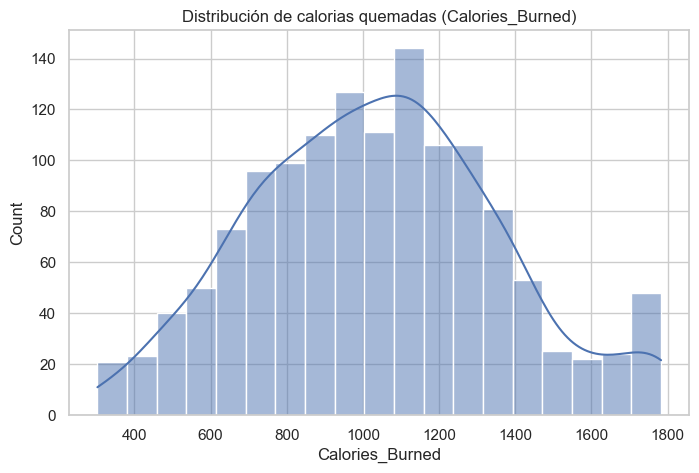

In [8]:
sns.histplot(df["Calories_Burned"], kde=True)
plt.title("Distribución de calorias quemadas (Calories_Burned)")
plt.show()

- 2.2 Relacion duración vs calorias

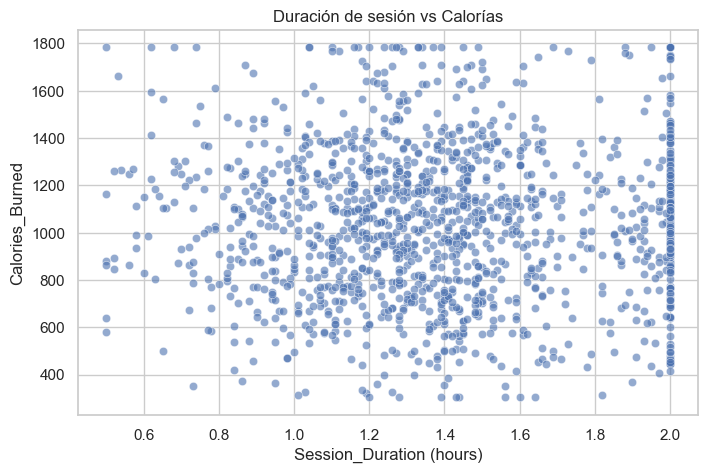

In [9]:
sns.scatterplot(
    data=df,
    x="Session_Duration (hours)",
    y="Calories_Burned",
    alpha=0.6
)
plt.title("Duración de sesión vs Calorías")
plt.show()

- 2.3 Relacion de calorias por tipo de entrenamiento

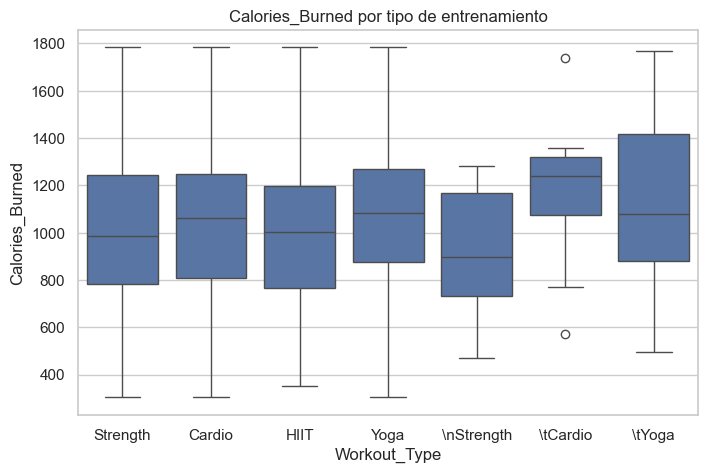

In [10]:
sns.boxplot(
    data=df,
    x="Workout_Type",
    y="Calories_Burned"
)
plt.title("Calories_Burned por tipo de entrenamiento")
plt.show()


- 2.4 Correlación entre variables numérica

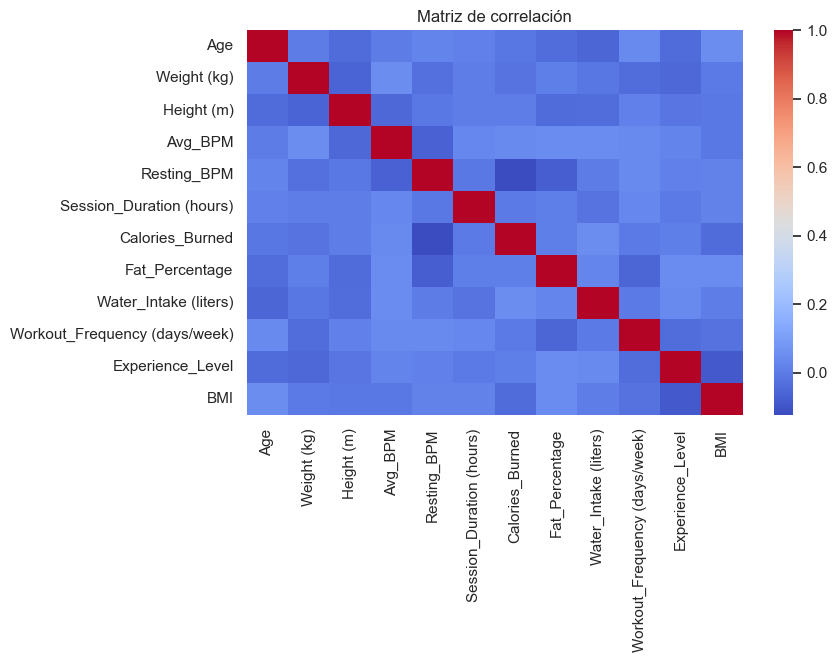

In [11]:
numeric_cols = df.select_dtypes(include=np.number)

corr = numeric_cols.corr()

sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Matriz de correlacion")
plt.show()

3. Selección de features

In [13]:
# 3.1 Definimos variables

TARGET = "Calories_Burned"

categorical_features = [
    "Gender",
    "Workout_Type",
    "Experience_Level"
]

numerical_features = [
    "Age",
    "Weight (kg)",
    "Height (m)",
    "Max_BPM",
    "Avg_BPM",
    "Resting_BPM",
    "Session_Duration (hours)",
    "Fat_Percentage",
    "Water_Intake (liters)",
    "Workout_Frequency (days/week)",
    "BMI"
]

# 3.2 Definimos X e y

X = df[categorical_features + numerical_features]
y = df[TARGET]

4. Train / Test Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

5. Preprocesamiento

In [15]:
# 5.1 Definimos los transformers

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])


In [16]:
# 5.2 Definimos ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


6. Definimos el modelo baseline (Linear Regression)

In [ ]:
# 6.1 Pipeline completo

linreg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

In [18]:
# 6.2 Entrenamiento

linreg_pipeline.fit(X_train, y_train)

ValueError: could not convert string to float: '\\t182'

## Limpieza del dataset

El dataset no estaba limpio, se va a identificar el punto de error y corregirlo

In [19]:
# Identificar la columna rota

for col in numerical_features:
    try:
        pd.to_numeric(df[col])
    except Exception as e:
        print(f"Error en columna: {col}")
        print(df[col].unique()[:10])

Error en columna: Max_BPM
<StringArray>
['174', '166', '187', '177', '161', '191', '181', '195', '186', '176']
Length: 10, dtype: str


In [20]:
# Limpiar el data frame

df["Max_BPM"] = (
    df["Max_BPM"]
    .astype(str)
    .str.replace(r"\s+", "", regex=True)
    .astype(float)
)

ValueError: could not convert string to float: '\\t182'

In [21]:
# Limpiar el data frame

df["Max_BPM"] = (
    df["Max_BPM"]
    .astype(str)
    .str.strip()
    .pipe(pd.to_numeric, errors="coerce")
)

In [22]:
# Identificar cuántos valores se dañaron

df["Max_BPM"].isna().sum()

np.int64(7)

In [ ]:
# Eliminar filas corruptas (recomendado en este proyecto)

df = df.dropna(subset=["Max_BPM"])

In [26]:
df

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,34.0,Female,86.7,1.86,174.0,152.0,74.0,1.12,712.0,Strength,12.8,2.4,5.0,2.0,14.31
1,26.0,Female,84.7,1.83,166.0,156.0,73.0,1.00,833.0,Strength,27.9,2.8,5.0,2.0,33.49
2,22.0,Male,64.8,1.85,187.0,166.0,64.0,1.24,1678.0,Cardio,28.7,1.9,3.0,2.0,12.73
3,54.0,Female,75.3,1.82,187.0,169.0,58.0,1.45,628.0,Cardio,31.8,2.4,4.0,1.0,20.37
4,34.0,Female,52.8,1.74,177.0,169.0,66.0,1.60,1286.0,Strength,26.4,3.2,4.0,2.0,20.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1354,54.0,Male,88.5,2.00,173.0,134.0,58.0,1.11,1388.0,HIIT,27.7,3.7,3.0,2.0,36.73
1355,52.0,Male,84.3,1.69,164.0,169.0,54.0,0.77,1367.0,HIIT,32.6,2.9,3.0,2.0,15.11
1356,47.0,Male,70.1,1.84,188.0,129.0,67.0,1.20,1261.0,Strength,28.4,2.5,3.0,2.0,17.99
1357,35.0,Male,49.3,1.71,180.0,152.0,73.0,1.04,956.0,Cardio,32.9,1.7,4.0,3.0,12.65


In [27]:
# Identificar la columna rota

for col in numerical_features:
    try:
        pd.to_numeric(df[col])
    except Exception as e:
        print(f"Error en columna: {col}")
        print(df[col].unique()[:10])

En caso de que ubiera varias columnas con el mismo problema:

```python
for col in numerical_features:
    df[col] = (
        df[col]
        .astype(str)
        .str.strip()
        .pipe(pd.to_numeric, errors="coerce")
    )

df = df.dropna(subset=numerical_features)
```

In [28]:
# Volvemos a rehacer split

X = df[categorical_features + numerical_features]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

Guardar el nuevo DataFrame limpiado (sin errores)

In [39]:
df.to_csv("../datasets/2-fitness-tracker-dataset-cleaned.csv", index=False)

Regresamos justo en donde nos quedamos, a entrenar el modelo

In [29]:
# 6.2 Entrenamiento

linreg_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

7. Modelo avanzado: Random Forest

In [30]:
# 7.1 Pipeline con Random Forest

# rf_pipeline = Pipeline(steps=[
#     ("preprocessor", preprocessor),
#     ("model", RandomForestRegressor(
#         n_estimators=200,
#         random_state=42,
#         n_jobs=-1
#     ))
# ])

rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    ))
])

In [31]:
# 7.2 Entrenamiento

rf_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

In [32]:
# 7.3 Evaluación del modelo

y_pred_rf = rf_pipeline.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MAE:  {mae_rf:.2f}")
print(f"Random Forest RMSE: {rmse_rf:.2f}")
print(f"Random Forest R2:   {r2_rf:.3f}")

TypeError: got an unexpected keyword argument 'squared'

In [34]:
# Calcular RMSE de manera manual

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MAE:  {mae_rf:.2f}")
print(f"Random Forest RMSE: {rmse_rf:.2f}")
print(f"Random Forest R2:   {r2_rf:.3f}")

Random Forest MAE:  257.50
Random Forest RMSE: 320.96
Random Forest R2:   -0.013


8. Comparación visual

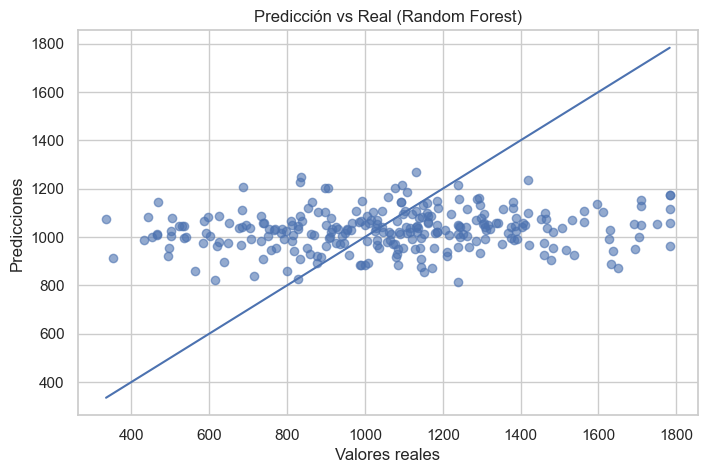

In [35]:
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()])
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Predicción vs Real (Random Forest)")
plt.show()

9. Revisar Interpretabilidad

In [36]:
# 9.1 Extraer nombres de features

feature_names = (
    rf_pipeline
    .named_steps["preprocessor"]
    .get_feature_names_out()
)

# 9.2 Importancias

importances = rf_pipeline.named_steps["model"].feature_importances_

feature_importance_df = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values(by="importance", ascending=False)
)

# 9.3 Top 10 features

feature_importance_df.head(10)

,feature,importance
10,num__BMI,0.105171
1,num__Weight (kg),0.102828
7,num__Fat_Percentage,0.097892
5,num__Resting_BPM,0.097255
6,num__Session_Duration (hours),0.087190
2,num__Height (m),0.086720
4,num__Avg_BPM,0.083663
3,num__Max_BPM,0.081509
0,num__Age,0.077230
8,num__Water_Intake (liters),0.067728


10. Guardar el modelo (pipeline completo)

In [37]:
joblib.dump(rf_pipeline, "../models/calories_burned_model.pkl")

['calories_burned_model.pkl']

11. Prueba manual de predicción

In [38]:
sample_input = pd.DataFrame([{
    "Age": 34,
    "Gender": "Female",
    "Weight (kg)": 86.7,
    "Height (m)": 1.86,
    "Max_BPM": 174,
    "Avg_BPM": 152,
    "Resting_BPM": 74,
    "Session_Duration (hours)": 1.12,
    "Workout_Type": "Strength",
    "Fat_Percentage": 12.8,
    "Water_Intake (liters)": 2.4,
    "Workout_Frequency (days/week)": 5,
    "Experience_Level": 2,
    "BMI": 14.31
}])

rf_pipeline.predict(sample_input)

array([832.32333333])

## Conclusiones

- ✔️ Dataset limpio
- ✔️ Un modelo de regresión sólido y competente
- ✔️ Pipeline robusto y reproducible
- ✔️ Listo para FastAPI
- ✔️ Notebook profesional
- ✔️ Artefacto listo para producción